In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your dataset
file_path = '/Users/ganeshgunda/my_btp/BTP_models/swelling_dataset1.csv'
data = pd.read_csv(file_path)

data.head()

,G,Sa,Si,C,Wl,Wp,Pi,BUW,W,E,Cc,S
0,0.0,2.0,10.0,88.0,89,47,42,18.151,10.007970,0.404451,0.711,0.547
1,0.0,2.0,10.0,88.0,89,47,42,18.150,10.000000,0.404300,0.711,0.547
2,0.0,2.0,10.0,88.0,89,47,42,18.149,9.993662,0.404180,0.711,0.547
3,0.0,2.0,10.0,88.0,89,47,42,18.155,10.028070,0.404833,0.711,0.546
4,3.3,7.2,62.2,27.3,93,47,46,20.083,11.870000,0.439830,0.747,0.539


In [3]:
# Split data into features (X) and target (y)
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column is the target


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)


In [7]:
# Train the model
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:

# Make predictions on both the training and testing sets
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

In [9]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

In [10]:
# Evaluate the model
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print("Extreme Gradient Boostinng metrics:")
# Print evaluation results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Extreme Gradient Boostinng metrics:
Mean Squared Error (MSE): 0.00010872344467097723
Root Mean Squared Error: 0.010427053498998518
R-squared (R2): 0.9803015708233865
Mean Absolute Error (MAE): 0.006167169868946075


In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# Define custom scoring functions
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Initialize the XGBoost regressor for cross-validation
xgb_model_cv = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Perform 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Compute cross-validation scores for each metric
mse_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=mse_scorer)
mae_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=mae_scorer)
r2_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=r2_scorer)

# Convert MSE to positive values and calculate RMSE
mse_scores = -mse_scores
rmse_scores = np.sqrt(mse_scores)

# Print the average values of the metrics
print("5-Fold Cross-Validation Average Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse_scores.mean():.4f}")
print(f"Mean Squared Error (MSE): {mse_scores.mean():.4f}")
print(f"Mean Absolute Error (MAE): {mae_scores.mean():.4f}")
print(f"R-squared (R²): {r2_scores.mean():.4f}")


5-Fold Cross-Validation Average Metrics:
Root Mean Squared Error (RMSE): 0.0090
Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): -0.0057
R-squared (R²): 0.9836


In [12]:
import shap
import matplotlib.pyplot as plt

def plot_xgb_shap(xgb_model, X_train_scaled, X_test_scaled, X_test_original, n_samples=100, output_file='/Users/ganeshgunda/my_btp/BTP_models/shap_plots/xgb_shap_feature_importance.png'):
    # Set figure style
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    
    # Calculate SHAP values for XGBoost
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)
    
    # Use original feature names if provided
    feature_names = X_test_original.columns.tolist()
    
    # Create SHAP summary plot
    shap.summary_plot(
        shap_values_xgb,
        X_test_scaled,
        plot_type="bar",
        feature_names=feature_names,
        show=False,  # Avoid showing the plot before saving
        title="XGBoost Feature Importance (SHAP)"
    )
    
    # Save the plot to a file (after it's generated)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')  # Save the figure as PNG
    plt.close()  # Close the plot to avoid displaying it twice
    
    return f"Plot saved as {output_file}"

# Assuming `xgb_model` is the trained XGBoost model and `X_train_scaled`, `X_test_scaled` are the features
# Assuming `data` is the original dataset, excluding the target variable

# Extract feature names
feature_names = data.columns[:-1]
X_test_original = pd.DataFrame(X_test_scaled, columns=feature_names)

# Call the function to generate and save the SHAP feature importance plot
output = plot_xgb_shap(xgb_model, X_train_scaled, X_test_scaled, X_test_original)
print(output)  # This will print: "Plot saved as xgb_shap_feature_importance.png"



Plot saved as /Users/ganeshgunda/my_btp/BTP_models/shap_plots/xgb_shap_feature_importance.png


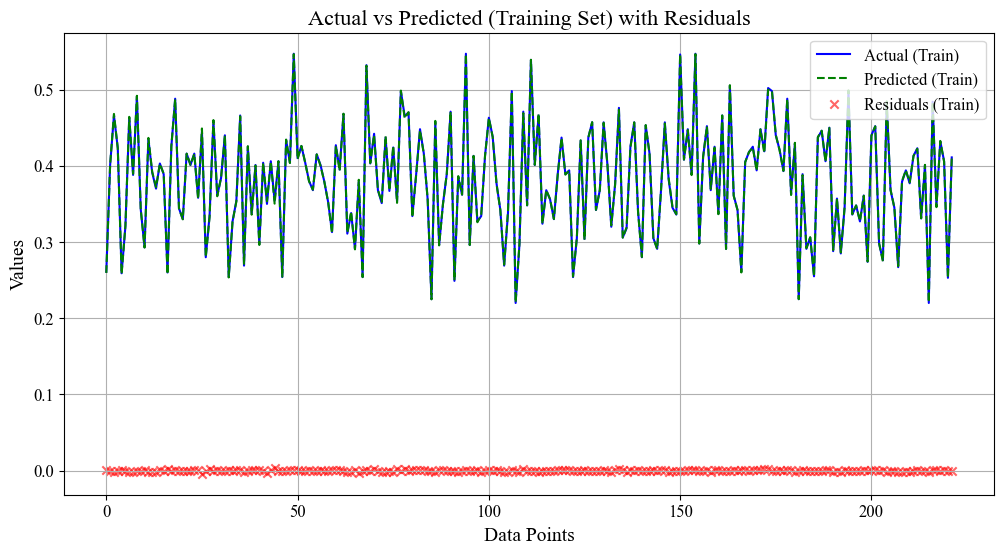

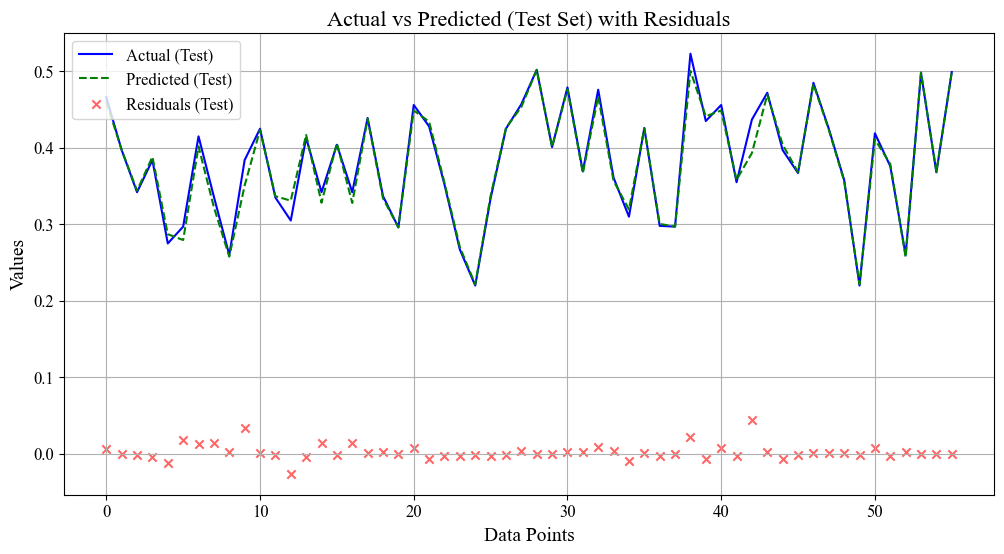

In [13]:
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot for the Training Set
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Actual (Train)', color='blue', linestyle='-')
plt.plot(range(len(y_train)), y_train_pred, label='Predicted (Train)', color='green', linestyle='--')
plt.scatter(range(len(y_train)), train_residuals, color='red', label='Residuals (Train)', alpha=0.6, marker='x')
plt.title('Actual vs Predicted (Training Set) with Residuals', fontsize=16)
plt.xlabel('Data Points', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('xgb_train_set.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot for the Testing Set
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual (Test)', color='blue', linestyle='-')
plt.plot(range(len(y_test)), y_test_pred, label='Predicted (Test)', color='green', linestyle='--')
plt.scatter(range(len(y_test)), test_residuals, color='red', label='Residuals (Test)', alpha=0.6, marker='x')
plt.title('Actual vs Predicted (Test Set) with Residuals', fontsize=16)
plt.xlabel('Data Points', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('xgb_test_set.png', dpi=300, bbox_inches='tight')
plt.show()

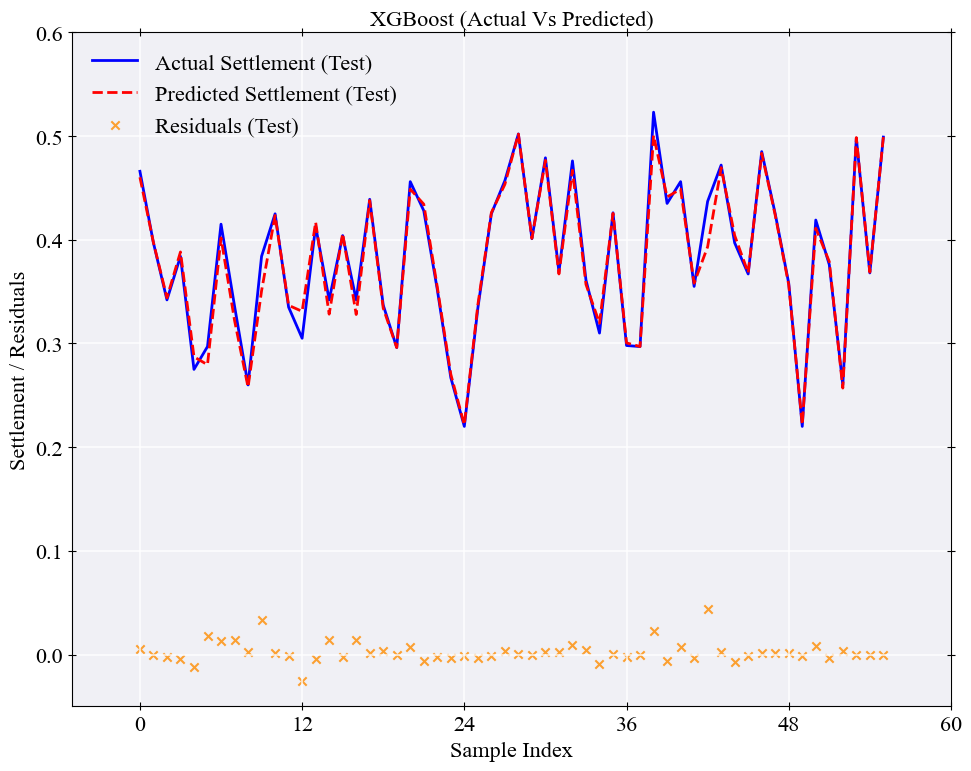

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def get_next_interval(value):
    if value <= 0.1:
        interval = 0.02
    elif value <= 0.5:
        interval = 0.1
    elif value <= 1:
        interval = 0.2
    elif value <= 5:
        interval = 1
    else:
        interval = 5
    return np.ceil(value / interval) * interval

# Assuming `y_test`, `y_test_pred`, and `test_residuals` are defined and loaded
# Set global font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# Plot for Test Data (Settlement and Residuals)
plt.figure(figsize=(10, 8))  # Wider plot for better readability

# Find max values for y-axis limit
test_max = max(
    np.max(np.abs(y_test)),
    np.max(np.abs(y_test_pred)),
    np.max(np.abs(test_residuals))
)
test_ylim = get_next_interval(test_max)

# Find the next interval for x-axis ticks
x_length = len(y_test)
x_max = get_next_interval(x_length)
x_ticks = np.arange(0, x_max + 1, x_max / 5)

# Test data: Actual vs Predicted Settlement
plt.plot(range(x_length), y_test, color='blue', label='Actual Settlement (Test)', linewidth=2, linestyle='-')
plt.plot(range(x_length), y_test_pred, color='red', label='Predicted Settlement (Test)', linewidth=2, linestyle='--')

# Overlay Residuals on the same plot
plt.scatter(range(x_length), test_residuals, color='darkorange', label='Residuals (Test)', marker='x', alpha=0.8)

# Set light gray background
plt.gca().set_facecolor('#f0f0f5')
plt.gcf().patch.set_facecolor('white')
plt.grid(True, color='white', linestyle='-', linewidth=1.5, alpha=0.7)

# Add title and labels
plt.title('XGBoost (Actual Vs Predicted)', fontsize=16)
plt.xlabel('Sample Index', fontsize=16)
plt.ylabel('Settlement / Residuals', fontsize=16)

# Add legend
plt.legend(frameon=False)

# Adjust the ticks and limits
plt.tick_params(axis='both', direction='inout', length=6, which='both', top=True, right=True)
plt.xticks(x_ticks, [f"{int(tick)}" for tick in x_ticks])
plt.xlim(-5, x_max)
plt.ylim(-0.05, test_ylim)

# Save and display the plot
plt.savefig('/Users/ganeshgunda/my_btp/BTP_models/results_images/XGB_test_settlement_styled.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

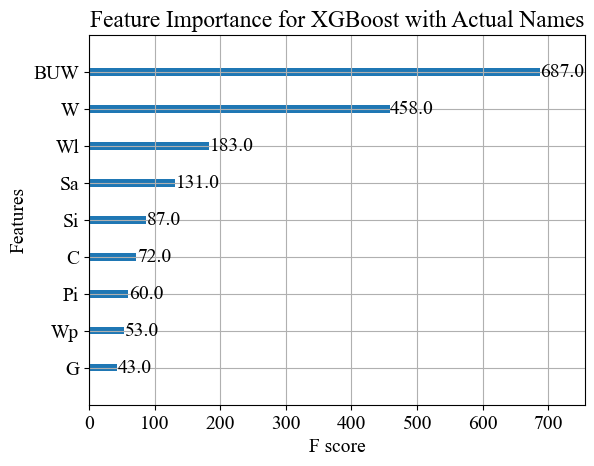

In [15]:
# Assuming X_train is a DataFrame with columns representing the feature names
feature_names = X_train.columns

# Fetch feature importance scores from the model
importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert importance dictionary keys from 'f0', 'f1', etc., to actual feature names
importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}

# Plot the feature importance with actual feature names
plt.figure(figsize=(10, 8))
xgb.plot_importance(importance, title="Feature Importance with Actual Names")
plt.title("Feature Importance for XGBoost with Actual Names")
plt.show()


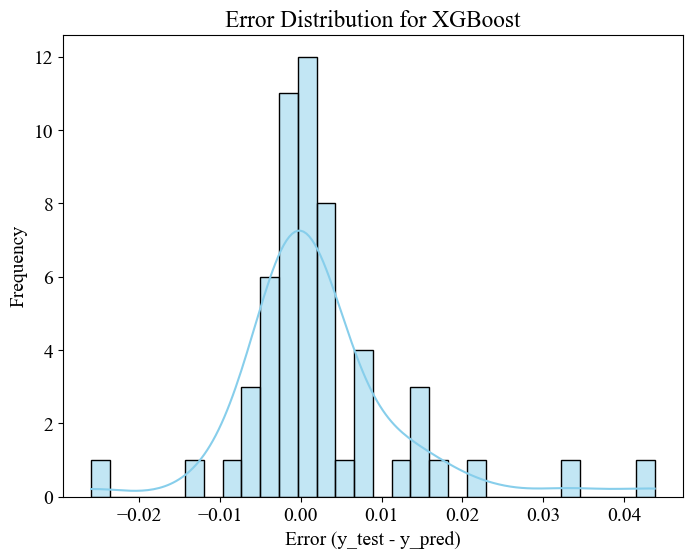

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_error_distribution(y_test, y_test_pred, model_name):
    errors = y_test - y_test_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(errors, bins=30, kde=True, color='skyblue')
    plt.title(f"Error Distribution for {model_name}")
    plt.xlabel("Error (y_test - y_pred)")
    plt.ylabel("Frequency")
    plt.show()

# Example usage for XGBoost model
plot_error_distribution(y_test, y_test_pred, "XGBoost")

In [17]:
# # Import necessary libraries for cross-validation
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# # %%
# # Initialize the XGBoost regressor with cross-validation
# xgb_model_cv = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# # %%
# # Define custom scoring functions for cross-validation
# mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# r2_scorer = make_scorer(r2_score)

# # %%
# # Perform 5-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# mse_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=mse_scorer)
# mae_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=mae_scorer)
# r2_scores = cross_val_score(xgb_model_cv, X, y, cv=kf, scoring=r2_scorer)

# # Convert MSE to positive values
# mse_scores = -mse_scores

# # %%
# # Print cross-validation results
# print(f"Cross-Validation Results:")
# print(f"Mean Squared Error (MSE): {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
# print(f"Mean Absolute Error (MAE): {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
# print(f"R-squared (R²): {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

# # %%
# # Train the model on the entire dataset after cross-validation
# xgb_model_cv.fit(X_train_scaled, y_train)

# # Make predictions on both the training and testing sets
# y_train_pred = xgb_model_cv.predict(X_train_scaled)
# y_test_pred = xgb_model_cv.predict(X_test_scaled)

# # %%
# # Calculate residuals
# train_residuals = y_train - y_train_pred
# test_residuals = y_test - y_test_pred

# # %%
# # Calculate metrics for test set
# mse = mean_squared_error(y_test, y_test_pred)
# mae = mean_absolute_error(y_test, y_test_pred)
# r2 = r2_score(y_test, y_test_pred)

# # Print test set evaluation results
# print(f"Test Set Evaluation Results:")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"R-squared (R²): {r2:.4f}")

# # %%
# # Plot for the Training Set
# plt.figure(figsize=(12, 6))
# plt.plot(range(len(y_train)), y_train, label='Actual (Train)', color='blue', linestyle='-')
# plt.plot(range(len(y_train)), y_train_pred, label='Predicted (Train)', color='green', linestyle='--')
# plt.scatter(range(len(y_train)), train_residuals, color='red', label='Residuals (Train)', alpha=0.6)
# plt.title('Actual vs Predicted (Training Set) with Residuals')
# plt.xlabel('Data Points')
# plt.ylabel('Values')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot for the Testing Set
# plt.figure(figsize=(12, 6))
# plt.plot(range(len(y_test)), y_test, label='Actual (Test)', color='blue', linestyle='-')
# plt.plot(range(len(y_test)), y_test_pred, label='Predicted (Test)', color='green', linestyle='--')
# plt.scatter(range(len(y_test)), test_residuals, color='red', label='Residuals (Test)', alpha=0.6)
# plt.title('Actual vs Predicted (Test Set) with Residuals')
# plt.xlabel('Data Points')
# plt.ylabel('Values')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot Residuals
# plt.figure(figsize=(10, 6))
# sns.histplot(test_residuals, kde=True, color='green', bins=30)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Residuals Distribution')
# plt.grid(True)
# plt.show()
